# XGBoost for Sink Particles
> Created Jan. 2025 <br>
> Nikhil Bisht<br>

In [14]:
# standard system modules
import os, sys
os.environ["PATH"] += os.pathsep + "/home/nbisht/myapps/bin/"
import h5py 
import argparse
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp


# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
import xgboost as xgb

import sklearn.metrics as skm

from tqdm import tqdm

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.json'

IMAGESIZE = 128

#In percentage
NTRAIN_percentage =  0.85
NVALID_percentage =  0.05
NTEST_percentage  =  0.15

#ALL_COLUMNS = ['Initial_Frame', 'Particle_id', 'X_i', 'Y_i', 'Z_i', 'Vx_i', 'Vy_i', 'Vz_i', 'Density_i', 'X_f', 'Y_f', 'Z_f', 'Vx_f', 'Vy_f', 'Vz_f', 'Density_f']
#FEATURES = ALL_COLUMNS[0:9]
#TARGET = ALL_COLUMNS[9:]

ALL_COLUMNS = ['Particle_id','Initial_Frame' , 'X_i', 'Y_i', 'Z_i', 'X_f', 'Y_f', 'Z_f']
FEATURES = ALL_COLUMNS[1:5]
TARGET = ALL_COLUMNS[5:]

FRAMES = np.arange(40,60, 1)
FRAME_DIFF = 30

NUM_X_TRAIN = 13

#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load data

In [3]:
#get core stuff
df_core_pids =[]
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    df_core_pids = tm['particle_ids'][()]

#get data and prepare sample
df_timeseries_core = pd.DataFrame([], columns=ALL_COLUMNS)
df_timeseries_noncore = pd.DataFrame([], columns=ALL_COLUMNS)
f =  h5py.File(DATAFILE, 'r')
for frame_num_index in range(len(FRAMES)):
    frame_num = FRAMES[frame_num_index]
    print(frame_num)
    temp_df_timeseries = pd.DataFrame([], columns=FEATURES)
    temp_final_df = pd.DataFrame([], columns=['Particle_id'])
    f_frame_ini = f[str(frame_num)]
    f_frame_fin = f[str(frame_num+FRAME_DIFF)]
    temp_df_timeseries['Initial_Frame'] = np.repeat(frame_num, len(f_frame_ini['Particle_id'][()]))
    temp_df_timeseries['Particle_id'] = f_frame_ini['Particle_id'][()]
    temp_df_timeseries['Particle_id'] = temp_df_timeseries['Particle_id'].astype('int32')
    temp_df_timeseries = temp_df_timeseries.set_index('Particle_id')
    temp_final_df['Particle_id'] = f_frame_fin['Particle_id'][()]
    temp_final_df['Particle_id'] = temp_final_df['Particle_id'].astype('int32')
    temp_final_df = temp_final_df.set_index('Particle_id')
    for cname in ['X', 'Y', 'Z']:
        temp_df_timeseries[cname+'_i'] = f_frame_ini[cname][()]
        temp_final_df[cname+'_f'] = f_frame_fin[cname][()]
    temp_df_timeseries = temp_df_timeseries.join(temp_final_df, on='Particle_id', how='inner')
    temp_df_timeseries_core = temp_df_timeseries.loc[df_core_pids]
    temp_df_timeseries_noncore = temp_df_timeseries.drop(df_core_pids)
    temp_df_timeseries_core = temp_df_timeseries_core.reset_index(names='Particle_id')
    temp_df_timeseries_noncore = temp_df_timeseries_noncore.reset_index(names='Particle_id')
    if frame_num_index == 0:
        df_timeseries_core = temp_df_timeseries_core
        df_timeseries_noncore = temp_df_timeseries_noncore
    else:
        df_timeseries_core = pd.concat([df_timeseries_core, temp_df_timeseries_core])
        df_timeseries_noncore = pd.concat([df_timeseries_noncore, temp_df_timeseries_noncore])

f.close()

print(len(df_core_pids))
print(len(df_timeseries_core))



40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
117364
2347280


In [17]:
df_timeseries = df_timeseries_core
df_timeseries.head(20)

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,X_f,Y_f,Z_f
0,1405,40,0.561639,0.160418,0.938095,0.589335,0.167772,0.919246
1,1488,40,0.066252,0.213458,0.937764,0.017390,0.243816,0.925989
2,1489,40,0.076220,0.226310,0.942724,0.035887,0.259322,0.920143
3,1490,40,0.084780,0.228440,0.947606,0.037667,0.259022,0.920247
4,1531,40,0.557085,0.164256,0.967639,0.591734,0.168231,0.926531
5,1551,40,0.058797,0.210295,0.936420,0.020432,0.246717,0.927614
6,1552,40,0.069444,0.221795,0.940237,0.044771,0.252411,0.925480
7,1553,40,0.075663,0.234251,0.946715,0.031831,0.268330,0.928681
8,1555,40,0.094986,0.246785,0.957175,0.040666,0.289092,0.955389
9,1558,40,0.127268,0.244349,0.976523,0.072504,0.288868,0.962504


In [18]:
pid = 1490
df_timeseries[df_timeseries['Particle_id'] == pid]

,Particle_id,Initial_Frame,X_i,Y_i,Z_i,X_f,Y_f,Z_f
3,1490,40,0.084780,0.228440,0.947606,0.037667,0.259022,0.920247
3,1490,41,0.082315,0.230020,0.946181,0.035664,0.260694,0.920705
3,1490,42,0.080323,0.231298,0.945037,0.035212,0.261074,0.920808
3,1490,43,0.079847,0.231604,0.944763,0.033668,0.262370,0.921159
3,1490,44,0.077383,0.233207,0.943339,0.031664,0.264067,0.921578
3,1490,45,0.074935,0.234793,0.941895,0.029735,0.265785,0.921932
3,1490,46,0.073238,0.235889,0.940843,0.029179,0.266311,0.922027
3,1490,47,0.072541,0.236337,0.940388,0.027926,0.267553,0.922242
3,1490,48,0.070233,0.237832,0.938808,0.026209,0.269358,0.922561
3,1490,49,0.068013,0.239283,0.937183,0.024571,0.271160,0.922957


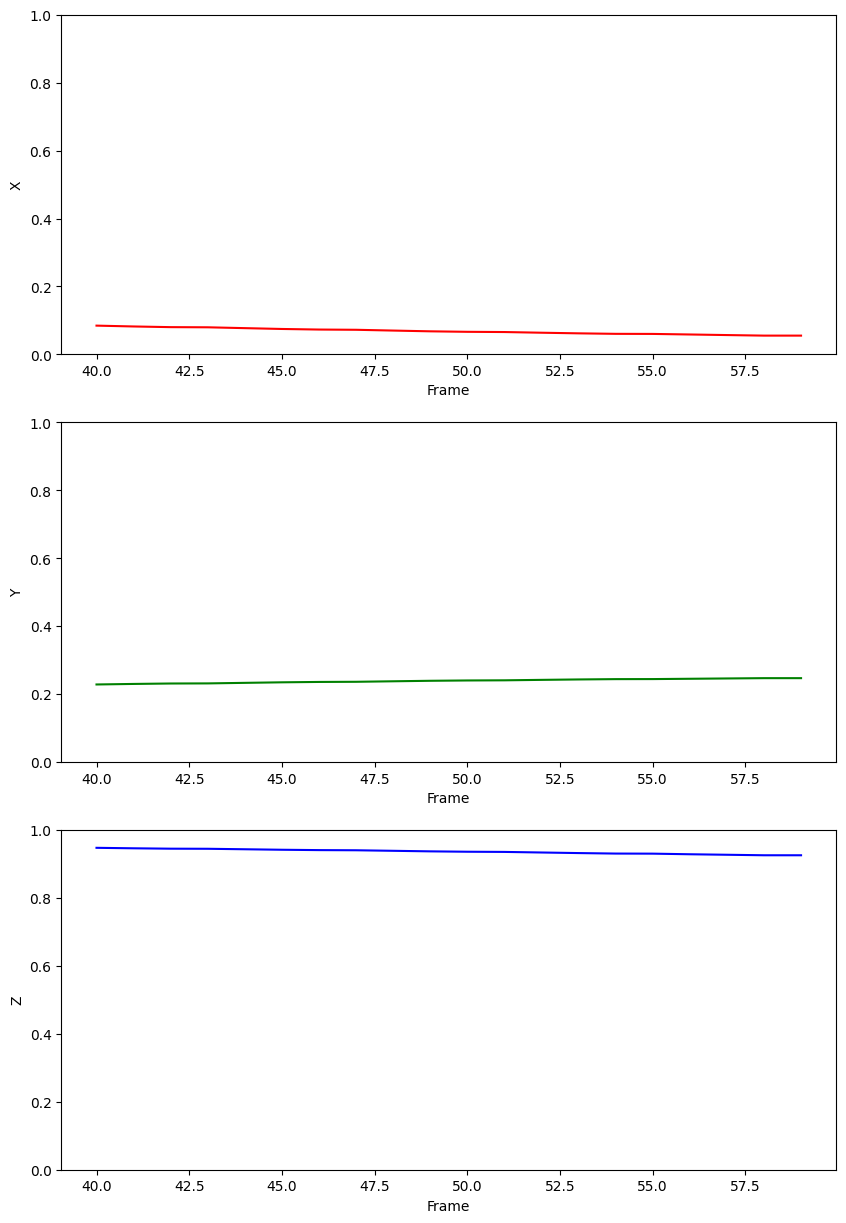

In [19]:
#Same Particle_ids across Initial_Frames
def get_track(df, particle_id):
    track_df = df[df['Particle_id'] == particle_id]
    xpos = track_df['X_i'].values
    ypos = track_df['Y_i'].values
    zpos = track_df['Z_i'].values
    frames = track_df['Initial_Frame'].values
    fig = plt.figure(figsize=(10, 15))
    ax = fig.add_subplot(311)
    ax.plot(frames, xpos, 'r')
    ax.set_xlabel('Frame')
    ax.set_ylabel('X')
    ax.set_ylim([0,1])
    ax = fig.add_subplot(312)
    ax.plot(frames, ypos, 'g')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Y')
    ax.set_ylim([0,1])
    ax = fig.add_subplot(313)
    ax.plot(frames, zpos, 'b')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Z')
    ax.set_ylim([0,1])
    plt.savefig('track_'+str(particle_id)+'.png')
    plt.show()

get_track(df_timeseries, pid)

In [20]:
def plot_data(df, name = '', suppress = False, just_i = False):
    if just_i==True:
        fig = plt.figure(figsize=(4.5*len(FRAMES), 4.5))
        for frame_num_index in range(len(FRAMES)):
            df_this_frame = df[df['Initial_Frame']==FRAMES[frame_num_index]]
            ax = plt.subplot2grid((1,len(FRAMES)), (0,frame_num_index))
            ax.set_title(f'Frame: {FRAMES[frame_num_index]}', fontsize=18)
            ax.set_xlim(-0.5, 1.5)
            ax.set_xlabel('X', fontsize=18)
            ax.set_ylim(-0.5, 1.5)
            ax.set_ylabel('Y', fontsize=18)
            ax.scatter(df_this_frame['X_i'], df_this_frame['Y_i'], s=1e-4, color='red')
    else:
        fig = plt.figure(figsize=(4.5*len(FRAMES), 8))
        for frame_num_index in range(len(FRAMES)):
            df_this_frame = df[df['Initial_Frame']==FRAMES[frame_num_index]]
            ax = plt.subplot2grid((2,len(FRAMES)), (0,frame_num_index))
            ax.set_title(f'Frame: {FRAMES[frame_num_index]}', fontsize=18)
            ax.set_xlim(-0.5, 1.5)
            ax.set_xlabel('X', fontsize=18)
            ax.set_ylim(-0.5, 1.5)
            ax.set_ylabel('Y', fontsize=18)
            ax.scatter(df_this_frame['X_i'], df_this_frame['Y_i'], s=3e-6, color='red')

            ax = plt.subplot2grid((2,len(FRAMES)), (1,frame_num_index))
            ax.set_title(f'Frame: {FRAMES[frame_num_index]+FRAME_DIFF}', fontsize=18)
            ax.set_xlim(-0.5, 1.5)
            ax.set_xlabel('X', fontsize=18)
            ax.set_ylim(-0.5, 1.5)
            ax.set_ylabel('Y', fontsize=18)
            ax.scatter(df_this_frame['X_f'], df_this_frame['Y_f'], s=3e-6, color='royalblue')
        
    
    fig.tight_layout()
    plt.savefig('Particles_'+name+'_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'.png')
    if not suppress:
        plt.show()

def plot_prediction(y_true,y_pred, append=''):
    fig = plt.figure(figsize=(12, 8))
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        ax.scatter(y_true[:,i], y_pred[:,i], c='crimson', s=1e-2)
        p1 = max(max(y_pred[:,i]), max(y_true[:,i]))
        p2 = min(min(y_pred[:,i]), min(y_true[:,i]))
        ax.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        ax.set_ylabel(TARGET[i])
        ax.set_xlim([-0.5,1.5])
        ax.set_ylim([-0.5,1.5])
    fig.tight_layout()
    plt.savefig('Particles_All_Frames_Frame'+str(FRAMES[0])+'_to_Frame'+str(FRAMES[-1])+'_Prediction'+append+'.png')
    plt.show()

#plot_data(df_timeseries_core)

## Split data

In [21]:
def df_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['del_X'] = df['X_f'] - df['X_i']
    df['del_Y'] = df['Y_f'] - df['Y_i']
    df['del_Z'] = df['Z_f'] - df['Z_i']
    df['X_op'] = np.where(np.abs(df['X_i'])<distance_condition, -1, +1)
    df['Y_op'] = np.where(np.abs(df['Y_i'])<distance_condition, -1, +1)
    df['Z_op'] = np.where(np.abs(df['Z_i'])<distance_condition, -1, +1)
    df['X_f'] = np.where(np.abs(df['del_X'])<distance_condition, df['X_f'], df['X_f']+df['X_op'])
    df['Y_f'] = np.where(np.abs(df['del_Y'])<distance_condition, df['Y_f'], df['Y_f']+df['Y_op'])
    df['Z_f'] = np.where(np.abs(df['del_Z'])<distance_condition, df['Z_f'], df['Z_f']+df['Z_op'])
    return df

def df_inverse_transform(df_test, distance_condition = 0.5):
    df = df_test.copy()
    df['X_f'] = np.where(np.abs(df['X_f'])>=1, df['X_f']-1, df['X_f'])
    df['X_f'] = np.where(np.abs(df['X_f'])<0, df['X_f']+1, df['X_f'])
    df['Y_f'] = np.where(np.abs(df['Y_f'])>=1, df['Y_f']-1, df['Y_f'])
    df['Y_f'] = np.where(np.abs(df['Y_f'])<0, df['Y_f']+1, df['Y_f'])
    df['Z_f'] = np.where(np.abs(df['Z_f'])>=1, df['Z_f']-1, df['Z_f'])
    df['Z_f'] = np.where(np.abs(df['Z_f'])<0, df['Z_f']+1, df['Z_f'])
    return df


def model_test(model, test_df, distance_condition = 0.5):
    y_pred = model.predict(test_df[FEATURES])
    y_pred_df = pd.DataFrame({'X_f': y_pred[:, 0], 'Y_f': y_pred[:, 1], 'Z_f': y_pred[:, 2]})
    y_pred_df =  df_inverse_transform(y_pred_df, distance_condition = distance_condition)
    
    return y_pred_df


In [22]:
df_timeseries_transformed = df_transform(df_timeseries)
#plot_data(df_timeseries, name = 'noncore_')
#plot_data(df_timeseries_transformed, name = 'noncore_extended')
X, y = df_timeseries_transformed[FEATURES], df_timeseries_transformed[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = NTEST_percentage,  random_state=seed)

y_test = df_inverse_transform(y_test)

## Train model
https://xgboost.readthedocs.io/en/stable/parameter.html

In [23]:
n_estimators    = 1000   #The number of trees in the ensemble, often increased until no further improvements are seen.
max_depth       = 7     #The maximum depth of each tree, often values are between 1 and 10.
eta             = 0.1  #The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.
subsample       = 1/2   #The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.
colsample_bytree= 1     #Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

#We will evaluate the model using the best practice of repeated k-fold cross-validation with 3 repeats and 10 folds.
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, subsample=subsample, colsample_bytree=colsample_bytree, device = 'cpu')

evaluate = 0
if evaluate:
    # evaluate model
    model_score = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-3)
    # force scores to be positive
    scores = np.absolute(model_score)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


In [24]:
print(len(X_train))
model.fit(X_train, y_train)

1995188


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device='cpu', early_stopping_rounds=None, enable_categorical=False,
             eta=0.1, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [25]:
#model.save_model("Core_Extended_v0_Frame"+str(FRAMES[0])+'_to_'+str(FRAMES[-1])+"_"+MODELFILE)

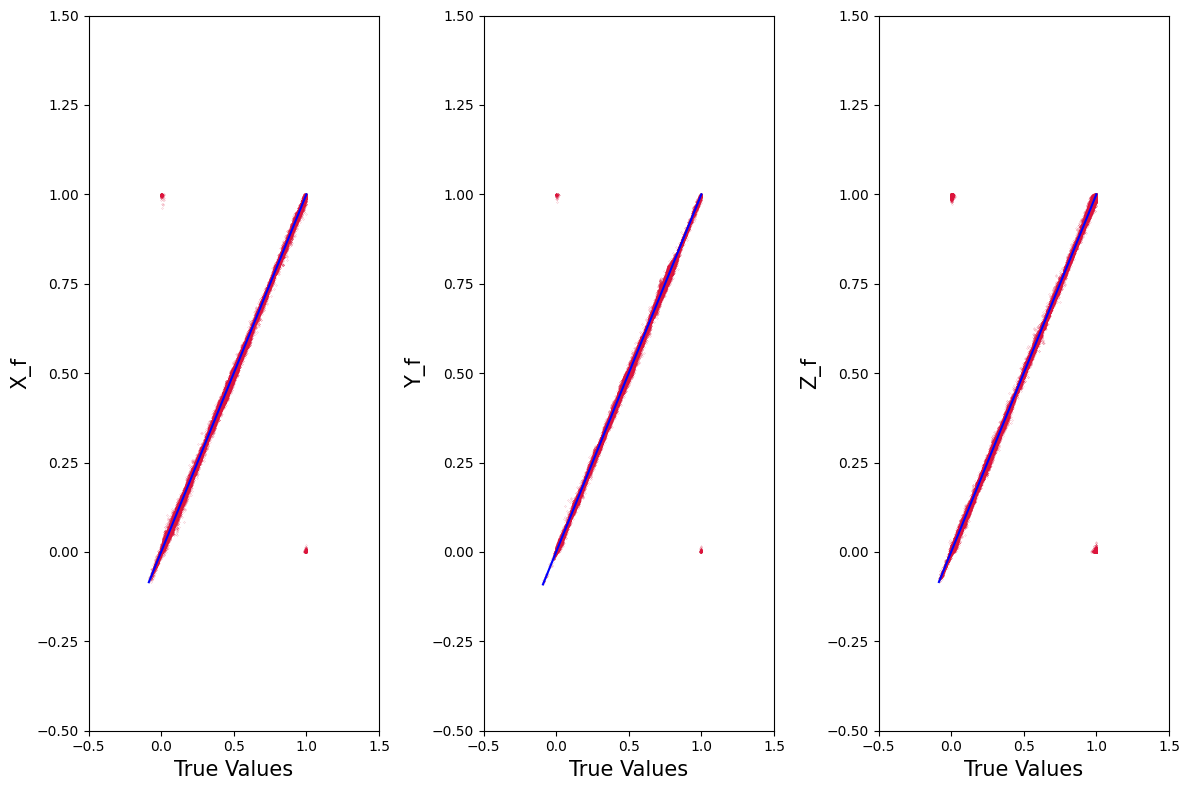

MSE: 0.003642
R2: 0.968


In [31]:
model = xgb.XGBRegressor()
mtype = 'Core'
model.load_model(mtype+'_Extended_v0_Frame40_to_59_nnmodel.json')
ypred, ytrue = model_test(model, X_test), y_test
plot_prediction(ytrue.to_numpy(),ypred.to_numpy(), append = '_'+mtype+'_Extended_v0')
mse = skm.mean_squared_error(ytrue.to_numpy(), ypred.to_numpy())
r2 = skm.r2_score(ytrue.to_numpy(),ypred.to_numpy())
print('MSE: %.6f' % mse)
print('R2: %.3f' % r2)



In [421]:
def mse_modded(y_true, y_pred):
    sqr_diff = np.abs(y_true - y_pred)
    sqr_diff = sqr_diff.flatten()
    sqr_add = 1-np.abs(y_true - y_pred)
    sqr_add = sqr_add.flatten()
    mse = 0
    for i in range(len(sqr_diff)):
        mse += min(sqr_diff[i], sqr_add[i])**2
    return mse/len(sqr_diff)

In [422]:
mse_m = mse_modded(ytrue.to_numpy(), ypred.to_numpy())
print('MSE modded: %.6f' % mse_m)


MSE modded: 0.000032


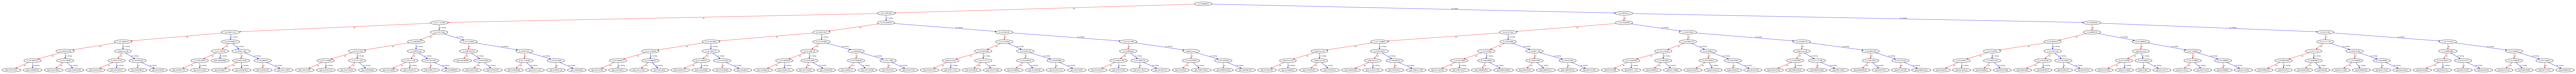

In [423]:
from io import BytesIO
import PIL
fig= plt.subplots(figsize=(210, 90))
g = xgb.to_graphviz(model, num_trees=0, ax=ax1)
s = BytesIO()
s.write(g.pipe(format="eps"))
s.seek(0)
img = np.array(PIL.Image.open(s))
plt.imshow(img)
plt.axis("off")
plt.savefig("Extended_V0_model.png", dpi = 100)
plt.show()

## Stats
| Model 	| Loss 	        | n_estimators 	| max_depth 	| eta 	| subsample 	| lambda 	| alpha 	| Mean MAE 	| mse 	| r2 	| remarks 	                                     |
|-------	|-------        |--------------	|-----------	|-----	|-----------	|--------	|-------	|----------	|------	|----	|---------	                                    |
|Simple V0	|squarederror   |1000           |  7         	|1e-2 	|1/30        	|   1    	|    1  	| 0.023  	|0.005   |0.951	|Fails at periodic wrap                          |
|Simple V1	|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.019 	|0.004  	|0.964	|Suprisingly better than V0                     |
|Simple V2	|squarederror   |1000          	|  7        	|1e-2   | 3/4        	|   1    	|    1  	| 0.019 	|0.004  	|0.963	|Same as V1                                       |
|Periodic V0|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.004 	|0.04  	|-0.882	|Worse than linear fit lol (wrap from 3. to .7)              |
|Periodic V1|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.007 	|0.09  	|-21 lol	|Octant breakdown  doesn't work, individual models are worse off               |
|Extended_V0|squarederror   |1000          	|  7        	|1e-2   | 1/2        	|   1    	|    1  	| 0.003     |0.00364|0.968| yay works better for both core and noncore, maybe avg of 2 models shifted?|